In [165]:
import os
import cv2
import sys
import math
import time
import serial
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import image as mpimg
import requests



# Adding the src folder in the current directory as it contains the script for Thymio and local occupancy
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio
robot = Thymio.serial(port='COM9', refreshing_rate=0.1)

url = "http://192.168.0.180:8080/shot.jpg"


SerialException: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)

In [200]:
MAP_SIZE = 30
max_val = MAP_SIZE

EMPTY = 0
OCCUPIED = 1
EXPANDED = 2
INCUBATION = 3

#Obstacle avoidance
PROXIMITY_THRESHOLD = 3800 #around 2cm
TIME_SLEEP_OBSTACLE = 0.1 #in seconds
TIME_SLEEP_DATA = 0.5 # 0.2 = 5Hz frequency
MOTOR_SPEED = 80 #both motor are set with this value (one in each direction)

SENSOR_0 = 0
SENSOR_1 = 1
SENSOR_2 = 2
SENSOR_3 = 3
SENSOR_4 = 4
SENSOR_5 = 5
SENSOR_6 = 6
ALL_FRONT_SENSOR = 5
PARTIALY_ALL_FRONT_SENSOR = 4
COMPTEUR = 6
DIST_WHEELS = 9.4

In [167]:
def create_empty_plot(max_val):
    """
    For plotting matters
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [168]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [169]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [170]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val=MAP_SIZE):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [171]:
def get_image():
    
#     filename = 'input_picture_2.png'
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)

    vid_frames = requests.get(url)
    img_array = np.array(bytearray(vid_frames.content), dtype = np.uint8)
    img = cv2.imdecode(img_array, -1)

    #plot
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     plt.figure(figsize=(7,7))
#     plt.imshow(img)
    img = img[125:1105,490:1720]
#     plt.figure(figsize=(7,7))
#     plt.imshow(img)
    
    return img

In [172]:
def expand_grid(occupancy_grid):
    
    nb_exp_turn = 2   
    
    for i in range(nb_exp_turn):
        occupancy_grid = expandation_turn(occupancy_grid)
        occupancy_grid = incubation_turn(occupancy_grid)
    
    return occupancy_grid

In [173]:
def expandation_turn(occupancy_grid):
    
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==OCCUPIED or occupancy_grid[i,j]==EXPANDED):
                
                if(j==0):
                    L_col = j
                else:
                    L_col = j-1

                if(i==0):
                    T_line = i
                else:
                    T_line = i-1

                if(j==MAP_SIZE-1):
                    R_col = j
                else:
                    R_col = j+1

                if(i==MAP_SIZE-1):
                    B_line = i
                else:
                    B_line = i+1

                TL = [T_line, L_col]
                T = [T_line, j]
                TR = [T_line, R_col]
                ML = [i, L_col]
                MR = [i, R_col]
                BL = [B_line, L_col]
                B = [B_line, j]
                BR = [B_line, R_col]

                boxes_to_test = [TL, T, TR, ML, MR, BL, B, BR]
                
                for k in boxes_to_test:
                    if(occupancy_grid[k[0],k[1]]==EMPTY):
                        occupancy_grid[k[0],k[1]]=INCUBATION
                        
    return occupancy_grid

In [174]:
def incubation_turn(occupancy_grid):

    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==INCUBATION):
                occupancy_grid[i,j]=EXPANDED
                
    return occupancy_grid

In [175]:
def get_occupancy_grid(img):

    np.set_printoptions(threshold=sys.maxsize)

#     filename = 'input_picture_2.png'
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)

    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(grayImage, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
#     plt.imshow(resized)
    height, width = resized.shape[:2] # Size of the map
    # fig, ax = create_empty_plot(width)

    ret,thresh1 = cv2.threshold(resized,90,255,cv2.THRESH_BINARY_INV)

    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(thresh1,cmap = 'gray')
    # plt.title('Threshold Image'), plt.xticks([]), plt.yticks([])
    #data = np.random.rand(max_val, max_val) * 20

    # cmap = colors.ListedColormap(['white', 'red'])
    occupancy_grid = thresh1.copy()
    occupancy_grid = occupancy_grid/255
    occupancy_grid = np.array(occupancy_grid, dtype=int)
    occupancy_grid = np.flip(occupancy_grid, 0)
    occupancy_grid = occupancy_grid.transpose()
    occupancy_grid = expand_grid(occupancy_grid)

    # ax.imshow(occupancy_grid, cmap=cmap)
    # plt.title("Map : free cells in white, occupied cells in red");

    # plt.show()
    occupancy_grid = np.array(occupancy_grid)
    
    return occupancy_grid

In [176]:
def get_data(img):
    original_height, original_width = img.shape[:2]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # resized = cv2.resize(img, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(resized[:,:,::-1])
    # plt.title('Resized Image'), plt.xticks([]), plt.yticks([])

    # plt.show

    ##################### GOAL ##########################
#     template_goal = img[780:862,100:190,:]
    template_goal = cv2.imread('goal_template - Copy.png')
#     cv2.imwrite('goal_template.png', template_goal)
#     plt.figure()
#     plt.imshow(template_goal[:,:,::-1])
#     plt.show()

    #c, w, h  = template_goal.shape[::-1]
    res = cv2.matchTemplate(img,template_goal,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    goal = min_loc
    x_goal=int(np.round(goal[0]*MAP_SIZE/original_width))
    y_goal=MAP_SIZE-int(np.round(goal[1]*MAP_SIZE/original_height)) #confirm height and width
    goal = (x_goal, y_goal)
    #print("Position of the goal [x, y] :", goal)

    ##################### ROBOT ##########################
#     template_back_point = img[593:615,610:635,:]
    template_back_point = cv2.imread('back_template - Copy.png')
#     cv2.imwrite('back_template.png', template_back_point)
#     plt.figure()
#     plt.imshow(template_back_point[:,:,::-1])
#     plt.show()

    res = cv2.matchTemplate(img,template_back_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    back = [min_loc[0], min_loc[1]]
    #print("Position of the back point [x, y] :", back)
    back[1] = original_height-back[1]


#     template_front_point = img[625:650,605:630,:]
    template_front_point = cv2.imread('front_template - Copy.png')
#     cv2.imwrite('front_template.png', template_front_point)
#     plt.figure()
#     plt.imshow(template_front_point[:,:,::-1])
#     plt.show()

    res = cv2.matchTemplate(img,template_front_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

#     plt.imshow(res)
#     plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    front = [min_loc[0], min_loc[1]]
    #print("Position of the front point [x, y] :", front)
    front[1] = original_height-front[1]
    

    ############ Compute pos and orientation ############

    x=(back[0]+front[0])/2
    y=(back[1]+front[1])/2
    x=int(np.round(x*MAP_SIZE/original_width))
    y=int(np.round(y*MAP_SIZE/original_height))

    v = [front[0]-back[0], front[1]-back[1]]

    theta = math.atan2(v[1],v[0])

    robot_pose = [x, y, theta]
    start = (x,y)
    #print("Position of the robot [x, y, theta] :", robot_pose)
    
    return robot_pose, start, goal

In [177]:
def findroute(start, goal, occupancy_grid):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes

In [178]:
def plot_map(visitedNodes, path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return

In [179]:
def plot_step(path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return

In [204]:
def set_course(target_list, idx, x, y, alpha):
    if (idx+3)<len(target_list[0]) :
        dy = target_list[1][idx+3] - y
        dx = target_list[0][idx+3] - x
    else:
        dy = target_list[1][idx] - y
        dx = target_list[0][idx] - x
    
    print("target : ", target_list[0][idx+3], target_list[1][idx+3])
    print("robot : ", x, y)
    
    alphatarg = math.atan2(dy,dx)
    dalpha = alphatarg - alpha
    
    while dalpha > math.pi :
        dalpha = dalpha - 2*math.pi
        
    while dalpha < -math.pi :
        dalpha = dalpha + 2*math.pi
    
    print(alpha, alphatarg, dalpha)
    
    if  dalpha > 0.2 :
        robot.set_var("motor.left.target", int(2**16)-int(MOTOR_SPEED/2)-5)
        robot.set_var("motor.right.target", int(MOTOR_SPEED/2)+5) 
    
    elif dalpha < -0.2:
        robot.set_var("motor.left.target", int(MOTOR_SPEED/2+5))
        robot.set_var("motor.right.target", int(2**16)-int(MOTOR_SPEED/2)-5)
    
    else:
        robot.set_var("motor.left.target", MOTOR_SPEED)
        robot.set_var("motor.right.target", MOTOR_SPEED) 
    return

In [205]:
def obstacle_avoidance(obstacle_direction,sensor_measurment):
    if(np.shape(obstacle_direction)[0] == ALL_FRONT_SENSOR)or(np.shape(obstacle_direction)[0] == PARTIALY_ALL_FRONT_SENSOR):
        if(sensor_measurment[SENSOR_1]>sensor_measurment[SENSOR_3]):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        else:
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    else:
        if (np.any(np.equal(obstacle_direction,SENSOR_0)))or(np.any(np.equal(obstacle_direction,SENSOR_1))):
            robot.set_var("motor.left.target", MOTOR_SPEED)
            robot.set_var("motor.right.target", 2**16-MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_3)))or(np.any(np.equal(obstacle_direction,SENSOR_4))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
        elif (np.any(np.equal(obstacle_direction,SENSOR_2))):
            robot.set_var("motor.left.target", 2**16-MOTOR_SPEED)
            robot.set_var("motor.right.target", MOTOR_SPEED)
    return

In [206]:
def go_to_goal(target_list):
    target_reached =0
    last_target_reached =0
    follow_obstacle = 0
    iteration = 0
    id_target = 1
    img = get_image()
    (robot_pos, start, goal) = get_data(img)
    x=robot_pos[0]
    y=robot_pos[1]
    alpha = robot_pos[2]
    target = [0,0]
        
    while (not last_target_reached) :
        target[0] = target_list[0][id_target]
        target[1] = target_list[1][id_target] 
        
        if target_list[0][len(target_list[0])-1] != goal[0] or target_list[1][len(target_list[1])-1] != goal[1] :
            return 0
        
        if follow_obstacle == 1 :
            robot.set_var("motor.left.target", MOTOR_SPEED)        
            robot.set_var("motor.right.target", MOTOR_SPEED)       
        else :
            set_course(target_list, id_target, x, y, alpha)

        sensor_measurment = robot["prox.horizontal"]

        if np.all(np.less(sensor_measurment, PROXIMITY_THRESHOLD)):
            pass
        else:
            obstacle_direction = np.nonzero(sensor_measurment)[0]
            while((np.any(np.greater(sensor_measurment, PROXIMITY_THRESHOLD)))and(np.all(np.not_equal(obstacle_direction, SENSOR_5)))and(np.all(np.not_equal(obstacle_direction, SENSOR_6)))):
                #robot.set_var('leds.top', 123)

                obstacle_avoidance(obstacle_direction,sensor_measurment)

                time.sleep(TIME_SLEEP_OBSTACLE)

                sensor_measurment = robot["prox.horizontal"]
                obstacle_direction = np.nonzero(sensor_measurment)[0]
                plot_step(path, start, goal, occupancy_grid)
                
            id_target = id_target + 10
            if id_target>len(target_list[0])-1:
                id_target = len(target_list[0])-1
            if id_target>len(target_list[1])-1:
                id_target = len(target_list[1])-1
            
        if (sensor_measurment[0] > 1000) or (sensor_measurment[4] > 1000) :
            follow_obstacle = 1
            iteration = 0
        else : 
            iteration = iteration + 1
            if iteration == COMPTEUR :
                follow_obstacle = 0
            
        time.sleep(TIME_SLEEP_DATA)
        
        img = get_image()
        (robot_pos, start, goal) = get_data(img)
        x=robot_pos[0]
        y=robot_pos[1]
        alpha = robot_pos[2]

        if x == target[0] and y == target[1] :
            target_reached = 1
            id_target = id_target+1
            if id_target>len(target_list[0])-1:
                id_target = len(target_list[0])-1
            if id_target>len(target_list[1])-1:
                id_target = len(target_list[1])-1
            
        if -1 < x-goal[0] < 1 and -1 < y-goal[1] < 1 :
            last_target_reached = 1
            robot.set_var("motor.left.target", 0)
            robot.set_var("motor.right.target", 0)
            
        plot_step(path, start, goal, occupancy_grid)
    return 1

target :  3 21
robot :  3 25
-1.5063694873693432 -1.5707963267948966 -0.06442683942555338
target :  3 21
robot :  3 25
-1.5385494443596428 -1.5707963267948966 -0.032246882435253754
target :  3 20
robot :  3 24
-1.5063694873693432 -1.5707963267948966 -0.06442683942555338
target :  3 20
robot :  3 22
-1.4743225516123097 -1.5707963267948966 -0.09647377518258682
target :  3 20
robot :  3 21
-1.446441332248135 -1.5707963267948966 -0.12435499454676147
target :  3 20
robot :  3 20
-1.4157995848709557 0.0 1.4157995848709557
target :  3 20
robot :  3 19
-1.2793395323170296 1.5707963267948966 2.8501358591119264
target :  3 20
robot :  4 19
-0.5456550545269917 2.356194490192345 2.9018495447193366
target :  3 20
robot :  4 20
0.11710874456686428 3.141592653589793 3.024483909022929
target :  3 20
robot :  4 20
0.9907935525872157 3.141592653589793 2.1507991010025775
target :  3 20
robot :  3 20
1.6845883339386047 0.0 -1.6845883339386047
target :  3 20
robot :  3 20
2.1353657204629966 0.0 -2.13536572

KeyboardInterrupt: 

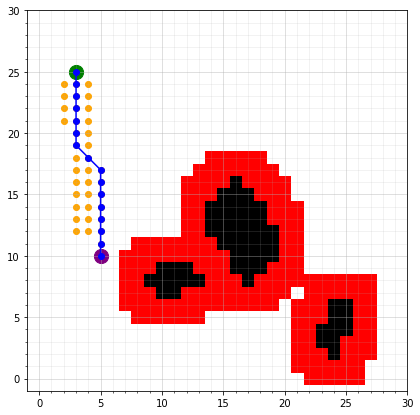

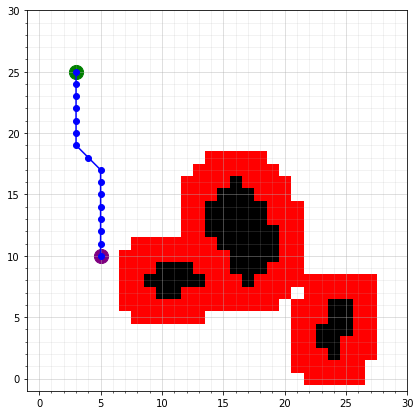

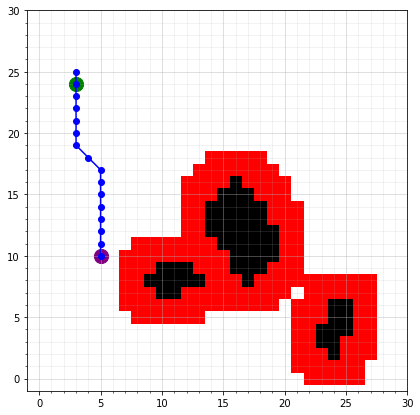

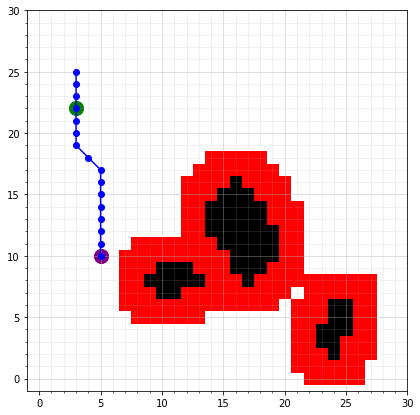

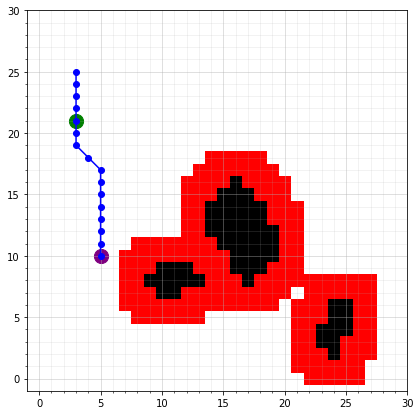

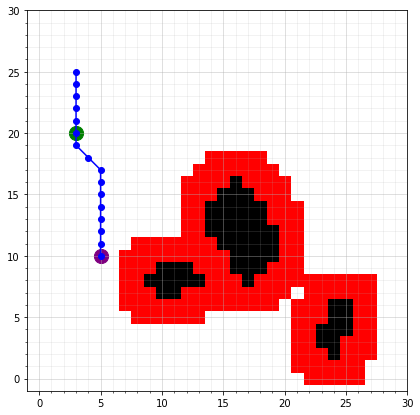

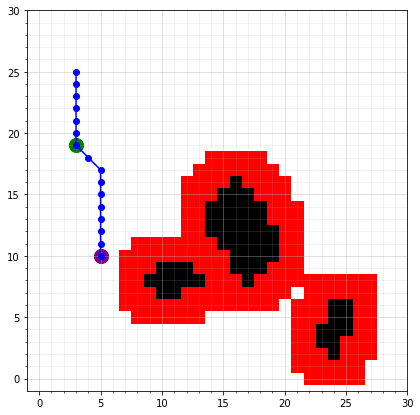

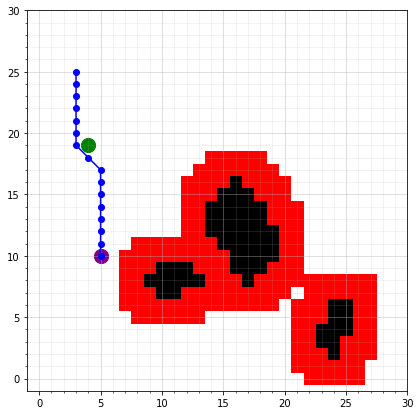

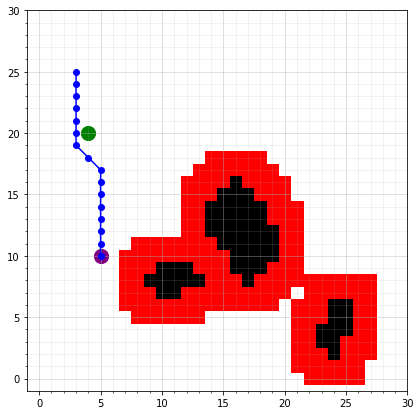

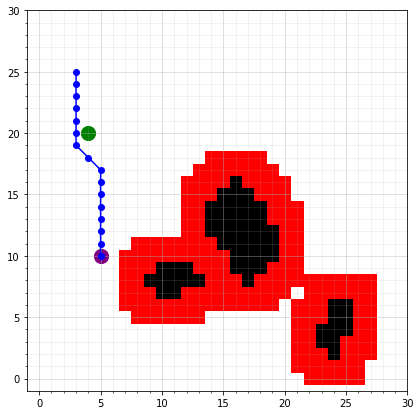

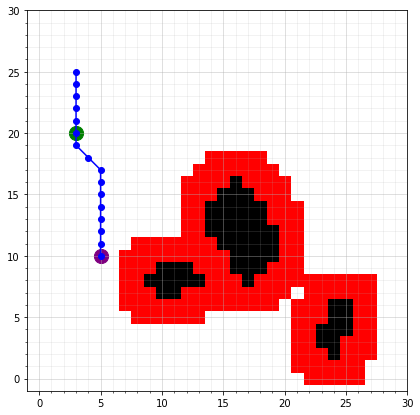

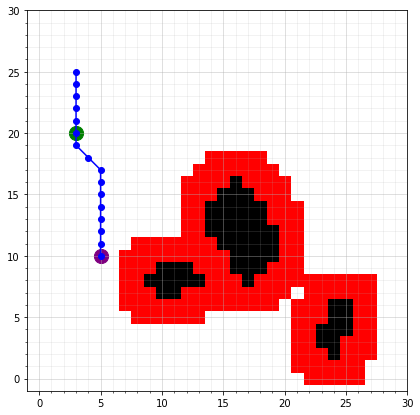

In [207]:
# Main:
# Get a picture of the map 
img = get_image()

# Get obstacle's postions
occupancy_grid = get_occupancy_grid(img)

# Get robot and goal's positions
(robot_pos, start, goal) = get_data(img)

# Find a route
path, visitedNodes = findroute(start, goal, occupancy_grid)

# Plot everything
plot_map(visitedNodes, path, start, goal, occupancy_grid)

go_to_goal(path)


# while(not(go_to_goal(path))):
#     robot.set_var("motor.left.target", 0)
#     robot.set_var("motor.right.target", 0)
#     img = get_image()
#     occupancy_grid = get_occupancy_grid(img)
#     path, visitedNodes = findroute(start, goal, occupancy_grid)
#     plot_map(visitedNodes, path, start, goal, occupancy_grid)

In [208]:
    robot.set_var("motor.left.target", 0)
    robot.set_var("motor.right.target", 0)

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\jaisw\Anaconda3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\jaisw\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\jaisw\OneDrive\Desktop\Basics of Mobile Robots\FInal Project\BOMR_2020\BOMR_2020-main\BOMR_2020-main\src\Thymio.py", line 340, in do_refresh
    self.get_variables()
  File "C:\Users\jaisw\OneDrive\Desktop\Basics of Mobile Robots\FInal Project\BOMR_2020\BOMR_2020-main\BOMR_2020-main\src\Thymio.py", line 499, in get_variables
    self.send(msg)
  File "C:\Users\jaisw\OneDrive\Desktop\Basics of Mobile Robots\FInal Project\BOMR_2020\BOMR_2020-main\BOMR_2020-main\src\Thymio.py", line 456, in send
    self.io.write(msg.serialize())
  File "C:\Users\jaisw\Anaconda3\lib\site-packages\serial\serialwin32.py", line 315, in write
    raise SerialException("WriteFile failed ({!r})".format(ctypes.WinError()))